### Potential Talents - Part 2b

----

### Objectives:

As a continuation of Part 1 and Part 2, this notebook aims to apply Word2Vec embeddings to the dataset and compare results with the previous parts.

### Summary:
    1) Setup & Data
    2) 
    3) 
    

----


## 0. Setup & Data

In [1]:
import os, math, random
import numpy as np
import pandas as pd
import torch
from torch import nn

In [2]:
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
df = pd.read_csv("./data/potential_talents.csv")
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]


(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

## 1. Load custom SGNS embeddings from Part 2

In [4]:
# Load SGNS checkpoint (from Part 2)
ckpt_path = "checkpoints/sgns_text8.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")


In [5]:
ckpt.keys()

dict_keys(['model_state', 'itos', 'config'])

In [6]:
ckpt['config'] 

{'embed_dim': 300}

In [7]:
ckpt['itos'][:10] 

['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']

In [8]:
print(type(ckpt['model_state']))
print(ckpt['model_state'].keys())

<class 'collections.OrderedDict'>
odict_keys(['emb_in.weight', 'emb_out.weight'])


In [9]:
itos = ckpt["itos"]
stoi = {w:i for i,w in enumerate(itos)}

E_in  = ckpt["model_state"]["emb_in.weight"].detach().float()   # [|V|, D]
E_out = ckpt["model_state"]["emb_out.weight"].detach().float()  # [|V|, D]

# as in Part2, use the avg 
E_comb = 0.5 * (E_in + E_out)
E_comb = E_comb / (E_comb.norm(dim=1, keepdim=True) + 1e-12)

E_comb.shape


torch.Size([71290, 300])

## 2) Tokenization for titles (keep it simple & consistent)

In [10]:
import nltk, string
from nltk.corpus import stopwords
_ = nltk.download('stopwords', quiet=True)
stop = set(stopwords.words('english'))

In [11]:
def tokenize_title(s: str):
    toks = nltk.word_tokenize(s.lower())
    toks = [t for t in toks if t.isalpha() and t not in stop]
    return toks

# quick check
[tokenize_title(t) for t in titles[:5]]


[['bauer',
  'college',
  'business',
  'graduate',
  'magna',
  'cum',
  'laude',
  'aspiring',
  'human',
  'resources',
  'professional'],
 ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'],
 ['aspiring', 'human', 'resources', 'professional'],
 ['people', 'development', 'coordinator', 'ryan'],
 ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]

## 3) Encode a title as the mean of its word vectors

In [12]:
E = E_comb

@torch.no_grad()
def encode_title_mean(text: str, E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    toks = tokenize_title(text)
    idxs = [stoi[t] for t in toks if t in stoi]
    if not idxs:
        return None
    v = E[idxs].mean(dim=0)                     # [D]
    v = v / (v.norm() + 1e-12)
    return v


In [13]:
# Rebuild title matrix with the combined embeddings
vecs, keep_idx = [], []
for i, title in enumerate(titles):
    v = encode_title_mean(title, E, stoi)
    if v is not None:
        vecs.append(v); keep_idx.append(i)

X_sgns_mean = torch.stack(vecs)
X_sgns_mean.shape, len(keep_idx)


(torch.Size([104, 300]), 104)

In [14]:
X_sgns_mean[0] 

tensor([ 0.0010, -0.0303,  0.0651, -0.0663, -0.0404, -0.0476,  0.0403, -0.0595,
         0.0352, -0.0484, -0.0376,  0.0648,  0.0703, -0.0477, -0.0194,  0.1158,
         0.0858,  0.0168,  0.0403, -0.0885,  0.0790, -0.0618, -0.0513, -0.0460,
        -0.0441, -0.0848,  0.0321, -0.0292,  0.0228, -0.0468, -0.0273, -0.0319,
        -0.0224, -0.0855,  0.0183, -0.0973,  0.0301, -0.0545, -0.0505,  0.0039,
        -0.0549,  0.0670, -0.0902, -0.0133,  0.0439, -0.0195, -0.0816,  0.0623,
         0.0429, -0.0189,  0.1062,  0.0619, -0.0351, -0.0368,  0.0094,  0.0243,
         0.0165, -0.0819,  0.0758,  0.0360,  0.0292,  0.0627, -0.1044,  0.0531,
         0.0519, -0.0369, -0.0752,  0.0118,  0.0724, -0.0568,  0.0394, -0.0821,
        -0.0056,  0.0752,  0.0618,  0.0449,  0.0371,  0.0209,  0.0658, -0.0298,
         0.0446, -0.0505, -0.0520, -0.0280,  0.0277, -0.0409, -0.0103, -0.0552,
        -0.0658, -0.0627, -0.0144, -0.0286,  0.0634,  0.0281,  0.0396,  0.0742,
        -0.0670,  0.0914,  0.0535,  0.05

In [15]:
import matplotlib.pyplot as plt

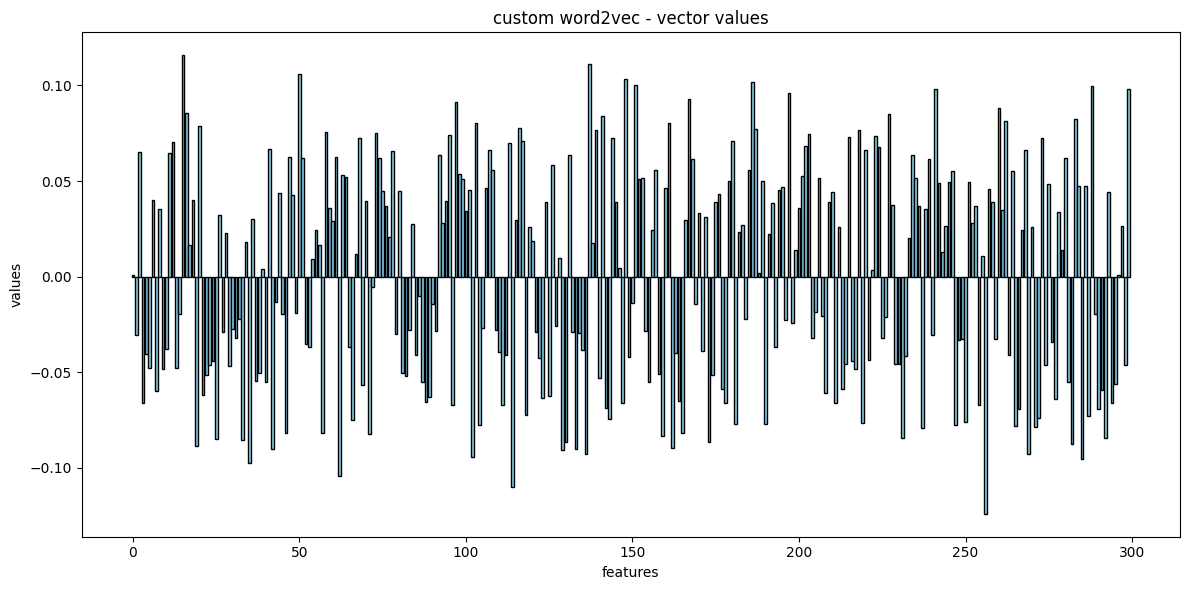

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(range(300), X_sgns_mean[0], color='skyblue', edgecolor='black')
plt.title("custom word2vec - vector values")
plt.xlabel("features")
plt.ylabel("values")
plt.tight_layout()
plt.show()

### 4) Cosine search over titles (dot product of normalized vectors)

In [17]:
# search using cosine similarity
@torch.no_grad()
def search_titles(query: str, X: torch.Tensor, titles: list[str], topk: int = 10):
    # use E (E_comb), not E_in
    q = encode_title_mean(query, E, stoi)
    if q is None:
        return [], "Query has no in-vocab tokens."
    sims = (X @ q)                               # [N_kept], cosine since rows are L2-normalized
    top = torch.topk(sims, k=min(topk, sims.numel()))
    rows = [(titles[keep_idx[i]], float(top.values[j].item())) 
            for j, i in enumerate(top.indices.tolist())]
    return rows, None

In [18]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_sgns_mean, titles, topk=10)
    print(f"\nQuery: {q}")
    if err: 
        print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")



Query: data scientist
   0.819  Information Systems Specialist and Programmer with a love for data and organization.
   0.726  Business Intelligence and Analytics at Travelers
   0.718  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.718  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.718  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.718  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.711  Undergraduate Research Assistant at Styczynski Lab
   0.710  Human Resources professional for the world leader in GIS software
   0.706  Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint
   0.705  Junior MES Engineer| Information Systems

Query: machine learning engineer
   0.795  Stu

## 4) Experiment with the GoogleNews Word2Vec vectors

A) Using Gensim’s downloader (auto-download, ~1.6GB):

In [19]:
import gensim.downloader as api

In [ ]:
w2v = api.load("word2vec-google-news-300")

[=============================---------------------] 59.7% 992.5/1662.8MB downloaded

In [ ]:
print("vocab size:", len(w2v), "dim:", w2v.vector_size)
w2v.most_similar("king")[:5]